# Figure 7

Pairwise differences in neurophysiological differentiation among stimuli

In [1]:
from itertools import product
from pathlib import Path

import pandas as pd
from IPython.display import Image

import analysis
from analysis import CONTINUOUS_NATURAL
from metadata import STIMULUS_METADATA

In [2]:
OUTPUT_DIR = Path('figures')

## Set up R

In [3]:
%load_ext rpy2.ipython

In [4]:
%%R
library(tidyverse)
library(broom)
library(ggplot2)
library(lme4)
library(multcomp)
library(emmeans)

theme_set(theme_minimal())

R[write to console]: Registered S3 methods overwritten by 'ggplot2':
  method         from 
  [.quosures     rlang
  c.quosures     rlang
  print.quosures rlang

R[write to console]: Registered S3 method overwritten by 'rvest':
  method            from
  read_xml.response xml2

R[write to console]: ── Attaching packages ─────────────────────────────────────── tidyverse 1.2.1 ──

R[write to console]: ✔ ggplot2 3.1.1       ✔ purrr   0.3.2  
✔ tibble  2.1.1       ✔ dplyr   0.8.0.1
✔ tidyr   0.8.3       ✔ stringr 1.4.0  
✔ readr   1.3.1       ✔ forcats 0.4.0  

R[write to console]: ── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()

R[write to console]: Loading required package: Matrix

R[write to console]: 
Attaching package: ‘Matrix’


R[write to console]: The following object is masked from ‘package:tidyr’:

    expand


R[write to console]: Loading required package: mvtnorm

R[wri

## Load data

In [5]:
df = pd.read_parquet("results/main.parquet")

In [6]:
# Compare continuous natural stimuli
df = df.loc[
    df['stimulus'].isin(CONTINUOUS_NATURAL)
]

In [7]:
response = "log(normalized differentiation)"

## Fit model

In [8]:
df.stimulus.unique()

array(['conspecifics', 'crickets (prey)', 'man writing', 'mousecam',
       'snake (predator)'], dtype=object)

In [9]:
formula = f"`{response}` ~ 1 + stimulus + (1 | session)"
reduced_formula = f"`{response}` ~ 1 + (1 | session)"
print(formula)
print(reduced_formula)

`log(normalized differentiation)` ~ 1 + stimulus + (1 | session)
`log(normalized differentiation)` ~ 1 + (1 | session)


In [10]:
%%R -i df -i formula -i reduced_formula

# Order factors
df$stimulus = fct_relevel(
    df$stimulus,
    "snake (predator)",
    "mousecam", 
    "conspecifics", 
    "crickets (prey)", 
    "man writing"
)

# Estimate models
model = lmer(formula, data=df, REML=FALSE)
reduced_model = lmer(reduced_formula, data=df, REML=FALSE)

# Compare models
model_comparison = anova(model, reduced_model)
print(model_comparison)

Data: df
Models:
reduced_model: `log(normalized differentiation)` ~ 1 + (1 | session)
model: `log(normalized differentiation)` ~ 1 + stimulus + (1 | session)
              Df    AIC    BIC  logLik deviance  Chisq Chi Df Pr(>Chisq)    
reduced_model  3 2926.0 2943.1 -1460.0   2920.0                             
model          7 2901.8 2941.7 -1443.9   2887.8 32.115      4  1.812e-06 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1


### Post hoc tests of pairwise differences in estimated marginal means among stimuli

In [11]:
%%R -o pairwise_differences -o confidence_intervals

# Estimate marginal means
posthoc = emmeans(model, list(pairwise ~ stimulus), adjust='tukey', alternative='two.sided')
confidence_intervals = confint(posthoc)
# effect_sizes = eff_size(posthoc, sigma=sigma(model), edf=df.residual(model))

means = posthoc$`emmeans of stimulus`
pairwise_differences = posthoc$`pairwise differences of stimulus`

R[write to console]: Cannot use mode = "kenward-roger" because *pbkrtest* package is not installed

R[write to console]: Cannot use mode = "satterthwaite" because *lmerTest* package is not installed



In [12]:
print(pairwise_differences)

 1                                  estimate     SE  df z.ratio p.value
 snake (predator) - mousecam          0.0560 0.0302 Inf 1.852   0.3434 
 snake (predator) - conspecifics      0.0975 0.0302 Inf 3.229   0.0109 
 snake (predator) - crickets (prey)   0.1186 0.0302 Inf 3.928   0.0008 
 snake (predator) - man writing       0.1585 0.0302 Inf 5.249   <.0001 
 mousecam - conspecifics              0.0416 0.0302 Inf 1.376   0.6430 
 mousecam - crickets (prey)           0.0627 0.0302 Inf 2.076   0.2306 
 mousecam - man writing               0.1026 0.0302 Inf 3.396   0.0061 
 conspecifics - crickets (prey)       0.0211 0.0302 Inf 0.699   0.9567 
 conspecifics - man writing           0.0610 0.0302 Inf 2.020   0.2562 
 crickets (prey) - man writing        0.0399 0.0302 Inf 1.321   0.6782 

Degrees-of-freedom method: asymptotic 
P value adjustment: tukey method for comparing a family of 5 estimates 



In [13]:
print(confidence_intervals)

$`emmeans of stimulus`
 stimulus         emmean     SE  df asymp.LCL asymp.UCL
 snake (predator)   2.07 0.0743 Inf      1.92      2.22
 mousecam           2.01 0.0743 Inf      1.87      2.16
 conspecifics       1.97 0.0743 Inf      1.83      2.12
 crickets (prey)    1.95 0.0743 Inf      1.81      2.10
 man writing        1.91 0.0743 Inf      1.77      2.06

Degrees-of-freedom method: asymptotic 
Confidence level used: 0.95 

$`pairwise differences of stimulus`
 1                                  estimate     SE  df asymp.LCL asymp.UCL
 snake (predator) - mousecam          0.0560 0.0302 Inf   -0.0264     0.138
 snake (predator) - conspecifics      0.0975 0.0302 Inf    0.0151     0.180
 snake (predator) - crickets (prey)   0.1186 0.0302 Inf    0.0363     0.201
 snake (predator) - man writing       0.1585 0.0302 Inf    0.0761     0.241
 mousecam - conspecifics              0.0416 0.0302 Inf   -0.0408     0.124
 mousecam - crickets (prey)           0.0627 0.0302 Inf   -0.0197     0.145
 mo

In [14]:
stimuli = [
    "snake (predator)",
    "mousecam", 
    "conspecifics", 
    "crickets (prey)", 
    "man writing"
]

for i in range(len(stimuli)):
    for j in range(i + 1, len(stimuli)):
        stim1, stim2 = stimuli[i], stimuli[j]
        print(stim1, '–', stim2)
        effect_size = analysis.cohens_d(
                df,
                a=stim1,
                b=stim2,
                value_col=response,
                label_col="stimulus",
        )
        display(effect_size.round(3))
        print('---')

snake (predator) – mousecam


mean difference    0.056
Cohen's d          0.090
dtype: float64

---
snake (predator) – conspecifics


mean difference    0.098
Cohen's d          0.156
dtype: float64

---
snake (predator) – crickets (prey)


mean difference    0.119
Cohen's d          0.181
dtype: float64

---
snake (predator) – man writing


mean difference    0.159
Cohen's d          0.232
dtype: float64

---
mousecam – conspecifics


mean difference    0.042
Cohen's d          0.068
dtype: float64

---
mousecam – crickets (prey)


mean difference    0.063
Cohen's d          0.098
dtype: float64

---
mousecam – man writing


mean difference    0.103
Cohen's d          0.154
dtype: float64

---
conspecifics – crickets (prey)


mean difference    0.021
Cohen's d          0.033
dtype: float64

---
conspecifics – man writing


mean difference    0.061
Cohen's d          0.091
dtype: float64

---
crickets (prey) – man writing


mean difference    0.040
Cohen's d          0.057
dtype: float64

---


### Plot

In [15]:
path = OUTPUT_DIR / "fig-7/pairwise_stimulus_estimated_marginal_mean_differences.png"
path.parent.mkdir(exist_ok=True)
path = str(path)

In [16]:
%%R -i path

p = (
    pwpp(means) 
    + scale_colour_grey(start=0, end=0) 
    + theme(text = element_text(family = 'Roboto'))
)

ggsave(
    path,
    p,
    width=7,
    height=3.5,
    dpi=300,
)

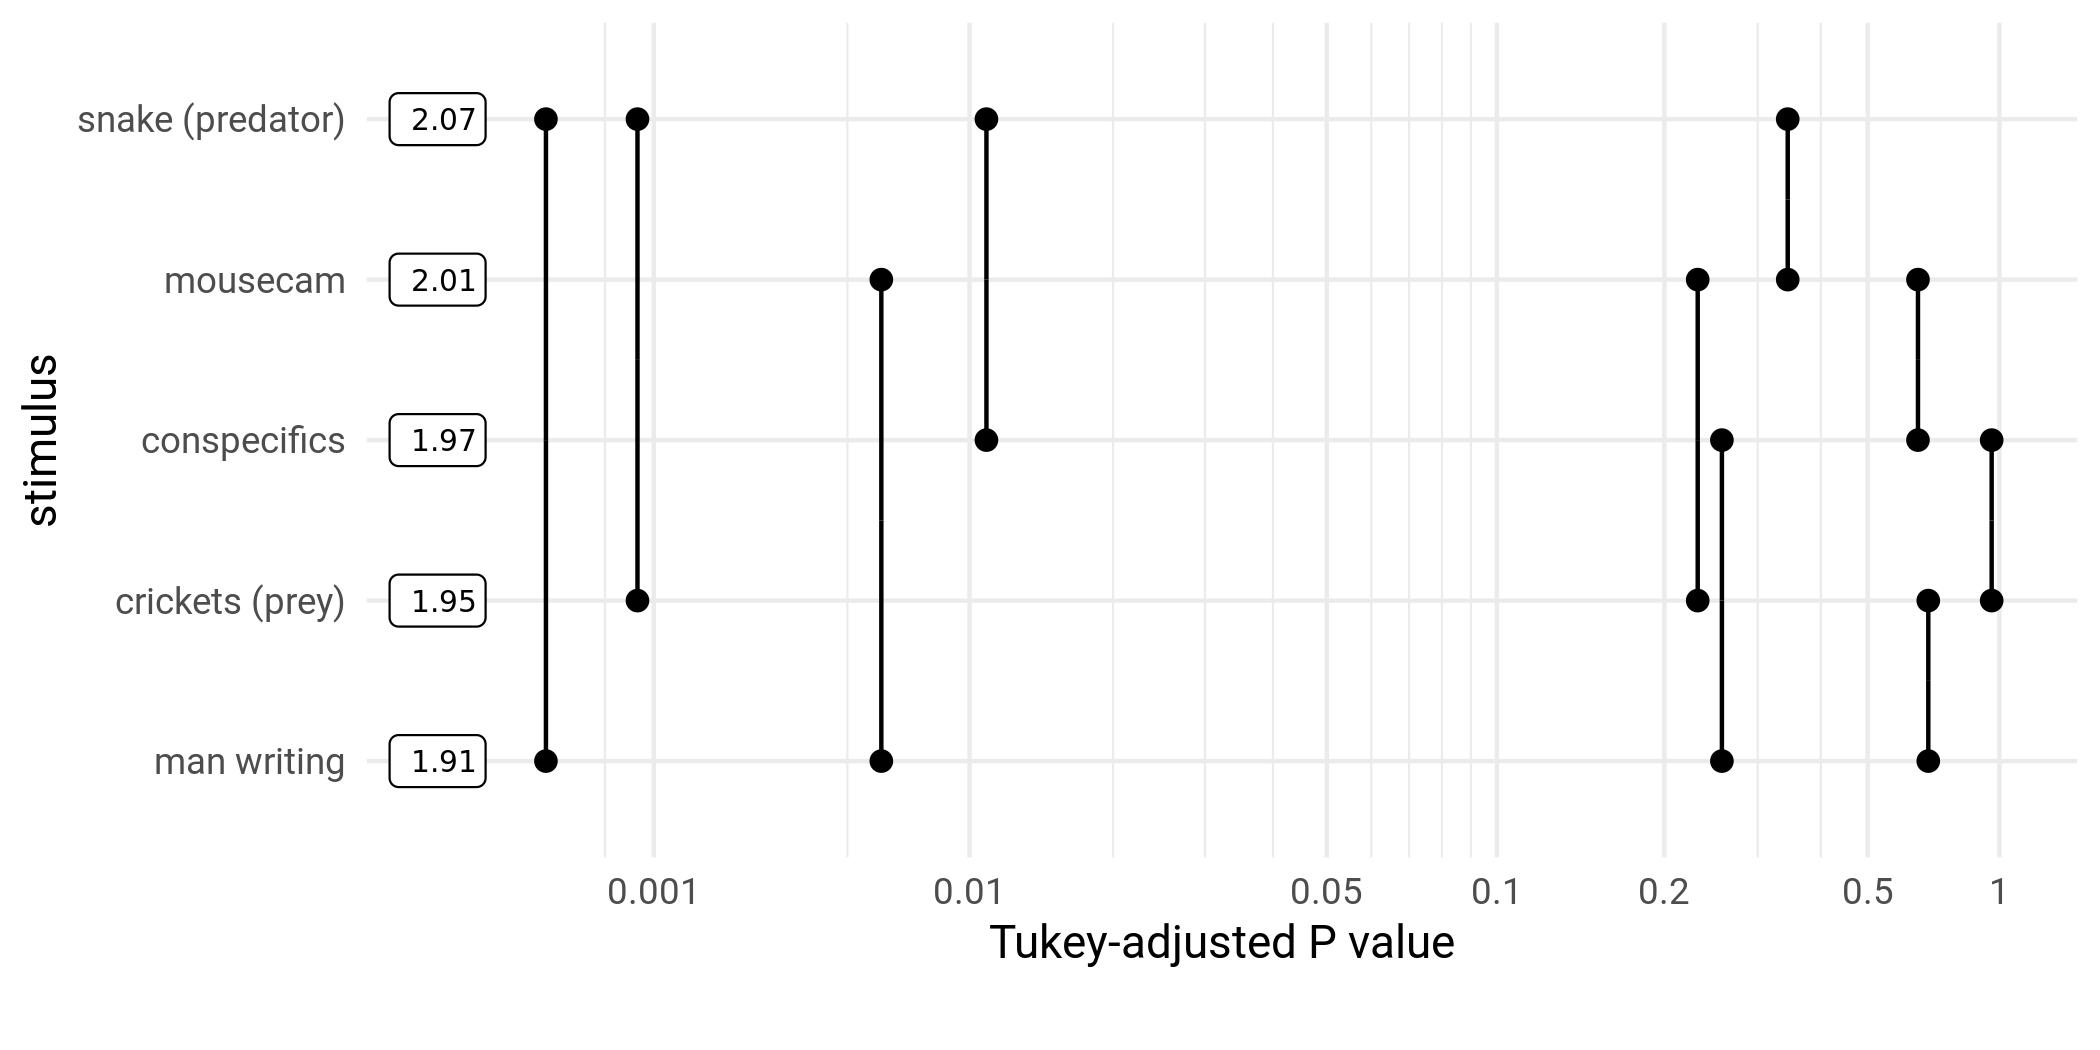

In [17]:
Image(filename=path)